** Problem Description **

* Data: Soil samples from various geographical regions in Africa and related MIR, spatial and geographical properties.
* Predict values for Ca, P, Sand, SOC, pH
* Evalulation Metric: MCRMSE ( Mean Column Root Mean Squared Error )

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, sys
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

basepath = os.path.expanduser('~/Desktop/src/African_Soil_Property_Prediction/')
sys.path.append(os.path.join(basepath, 'src'))

np.random.seed(0)

In [2]:
# load files
train = pd.read_csv(os.path.join(basepath, 'data/raw/training.csv'))
test = pd.read_csv(os.path.join(basepath, 'data/raw/sorted_test.csv'))
sample_sub = pd.read_csv(os.path.join(basepath, 'data/raw/sample_submission.csv'))

In [3]:
train.head(2)

,PIDN,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,...,REF7,RELI,TMAP,TMFI,Depth,Ca,P,pH,SOC,Sand
0,XNhoFZW5,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,...,-0.646673,1.687734,0.190708,0.056843,Topsoil,-0.295749,-0.041336,-1.129366,0.353258,1.269748
1,9XNspFTd,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,...,-0.646673,1.687734,0.190708,0.056843,Subsoil,-0.387442,-0.231552,-1.531538,-0.264023,1.692209


In [4]:
test.head(2)

,PIDN,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,...,LSTD,LSTN,REF1,REF2,REF3,REF7,RELI,TMAP,TMFI,Depth
0,09gt9UK5,0.210899,0.209221,0.207645,0.208714,0.211972,0.213562,0.211267,0.208248,0.207341,...,-0.009394,0.197885,-0.622545,-0.548238,-0.637681,-0.413306,-0.130139,0.154013,-0.033905,Subsoil
1,0BVvxJ6a,0.191650,0.184120,0.177070,0.180624,0.192343,0.197502,0.187655,0.175447,0.172639,...,-0.277944,-0.851643,-0.792000,-1.058442,-0.792961,-0.785786,-0.588855,0.106200,0.559694,Subsoil


** Check if there are any missing values in the dataset. **

In [5]:
print('===== Checking if there are any missing values in the training dataset ======')
print(train.isnull().any().sum())

===== Checking if there are any missing values in the training dataset ======
0


In [6]:
print('===== Checking if there are any missing values in the test dataset =======')
print(test.isnull().any().sum())

===== Checking if there are any missing values in the test dataset =======
0


** So there are no missing values in the dataset. **

** Summary Statistics for all the variables. **

In [21]:
non_infrared_features = train.columns[3579:-5]

In [22]:
print('====== Summary statistics for training dataset ======\n')
print(train[non_infrared_features].describe())

====== Summary statistics for training dataset ======

              BSAN         BSAS         BSAV          CTI         ELEV  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean     -0.572226    -0.623242    -0.691976    -0.213203     0.533953   
std       0.235748     0.239737     0.281652     0.661576     1.396132   
min      -1.007246    -0.972727    -1.175812    -0.945472    -1.326726   
25%      -0.739130    -0.781818    -0.895857    -0.548063    -0.812249   
50%      -0.608696    -0.681818    -0.761478    -0.344714     0.867038   
75%      -0.463768    -0.563636    -0.604703    -0.104917     1.292428   
max       0.217391     0.200000     0.223964     3.596526     4.891537   

               EVI         LSTD         LSTN         REF1         REF2  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean      0.698859    -0.413636    -0.092569    -0.698528    -0.506340   
std       0.683280     0.686773     0.861165     0.27210

In [23]:
print('====== Summary statistics for test dataset ======\n')
print(test[non_infrared_features].describe())

====== Summary statistics for test dataset ======

             BSAN        BSAS        BSAV         CTI        ELEV         EVI  \
count  727.000000  727.000000  727.000000  727.000000  727.000000  727.000000   
mean    -0.617497   -0.639852   -0.671307   -0.108035    0.227325    0.583861   
std      0.256327    0.276273    0.307626    0.791396    1.152433    0.727844   
min     -1.000000   -1.036364   -1.142217   -1.001026   -1.395768   -0.800292   
25%     -0.789855   -0.818182   -0.873460   -0.477960   -0.870156    0.164723   
50%     -0.673913   -0.718182   -0.739082   -0.321260    0.336971    0.507289   
75%     -0.528986   -0.536364   -0.537514   -0.016621    1.205568    1.043003   
max      0.391304    0.436364    0.403136    3.596526    2.646548    2.201895   

             LSTD        LSTN        REF1        REF2        REF3        REF7  \
count  727.000000  727.000000  727.000000  727.000000  727.000000  727.000000   
mean    -0.364974    0.269816   -0.668341   -0.572728   -

** Find similar soil instances. **

In [20]:
train.columns[-80:-40]

Index(['m711.612', 'm709.684', 'm707.755', 'm705.827', 'm703.898', 'm701.97',
       'm700.041', 'm698.113', 'm696.184', 'm694.256', 'm692.327', 'm690.399',
       'm688.47', 'm686.542', 'm684.614', 'm682.685', 'm680.757', 'm678.828',
       'm676.9', 'm674.971', 'm673.043', 'm671.114', 'm669.186', 'm667.257',
       'm665.329', 'm663.4', 'm661.472', 'm659.543', 'm657.615', 'm655.686',
       'm653.758', 'm651.829', 'm649.901', 'm647.972', 'm646.044', 'm644.115',
       'm642.187', 'm640.258', 'm638.33', 'm636.401'],
      dtype='object')

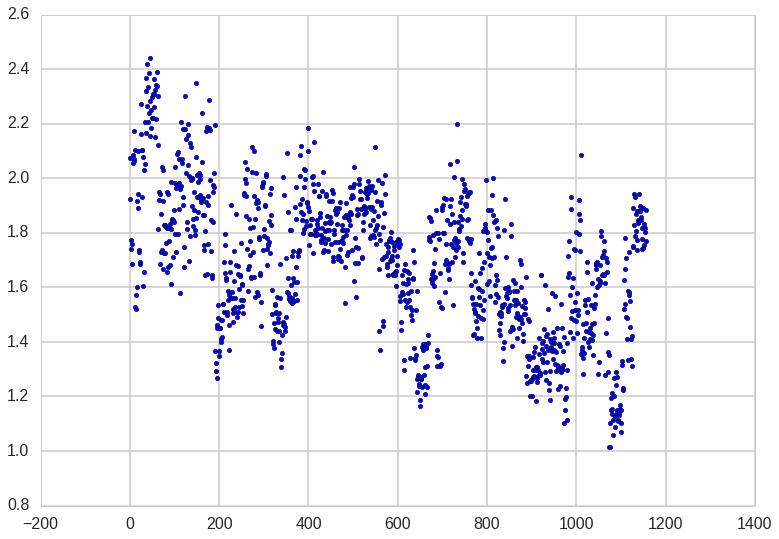

In [23]:
plt.scatter(np.arange(0, len(train)), train['m707.755']);

** Mean values of features in the training set and test set **

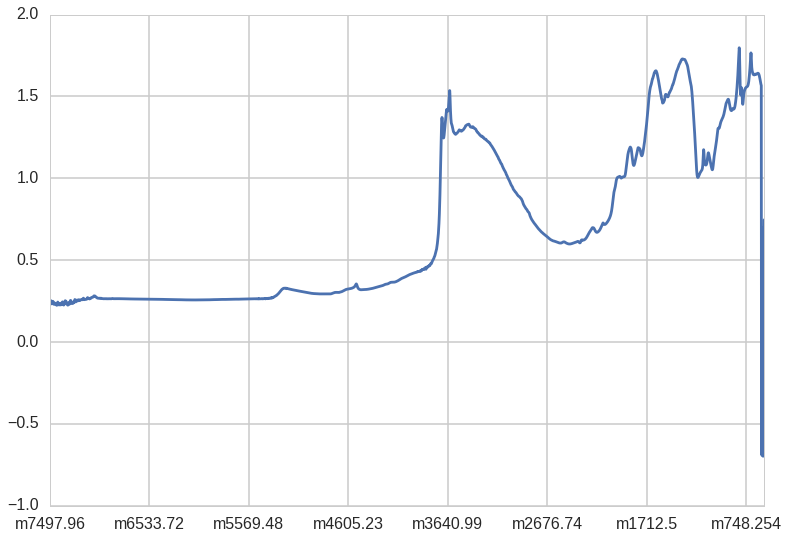

In [37]:
train[train.columns[1:-5]].mean(axis=0).plot();

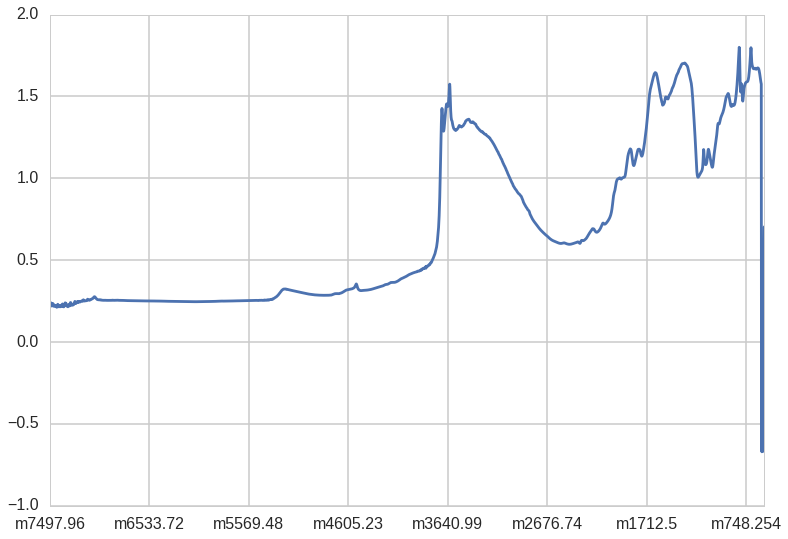

In [38]:
test[train.columns[1:-5]].mean(axis=0).plot();

** Median values of features in the training set and test set **

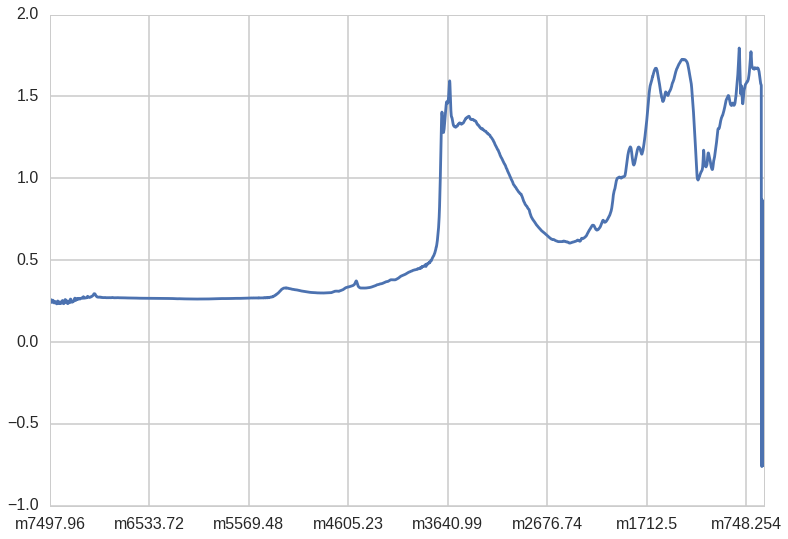

In [39]:
train[train.columns[1:-5]].median(axis=0).plot();

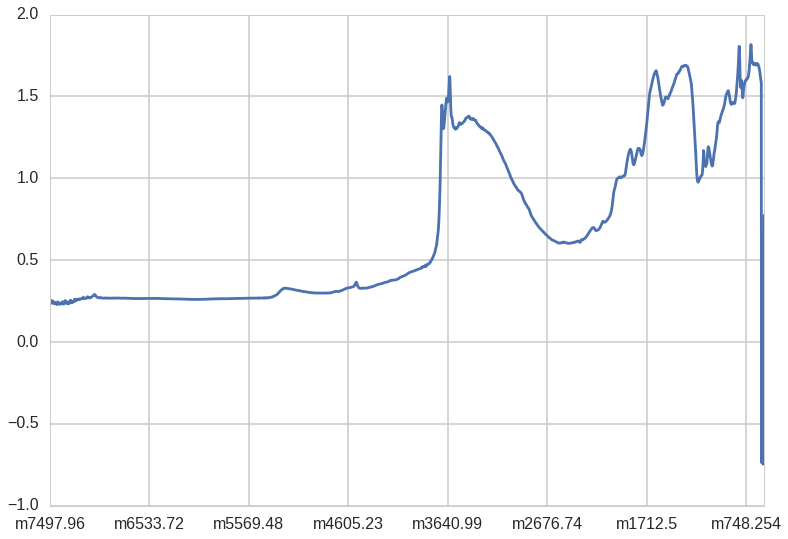

In [40]:
test[train.columns[1:-5]].median(axis=0).plot();

** Standard deviation of features in the training and test set. **

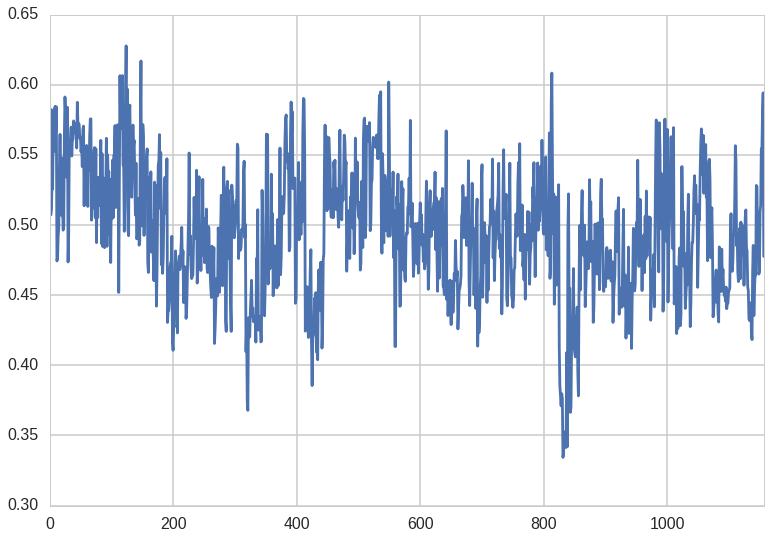

In [25]:
train[train.columns[1:-5]].std(axis=1).plot()

** Plot for Ca **

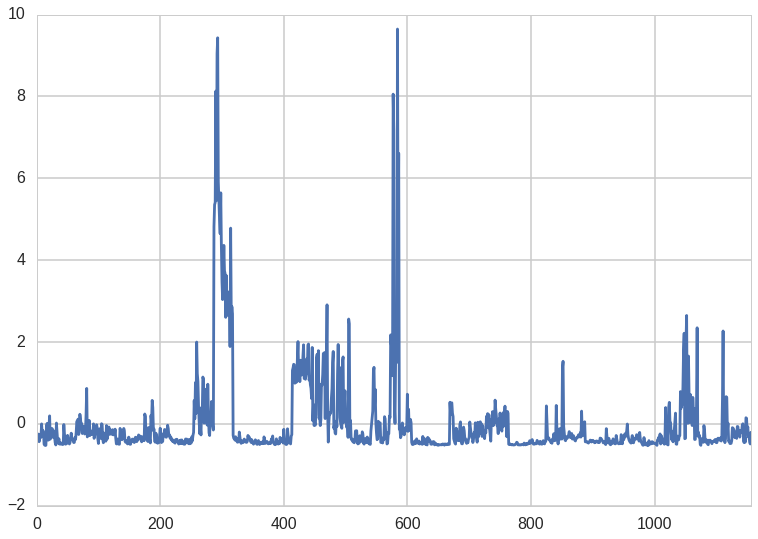

In [33]:
train[train.columns[-5]].plot()

** Plot P **

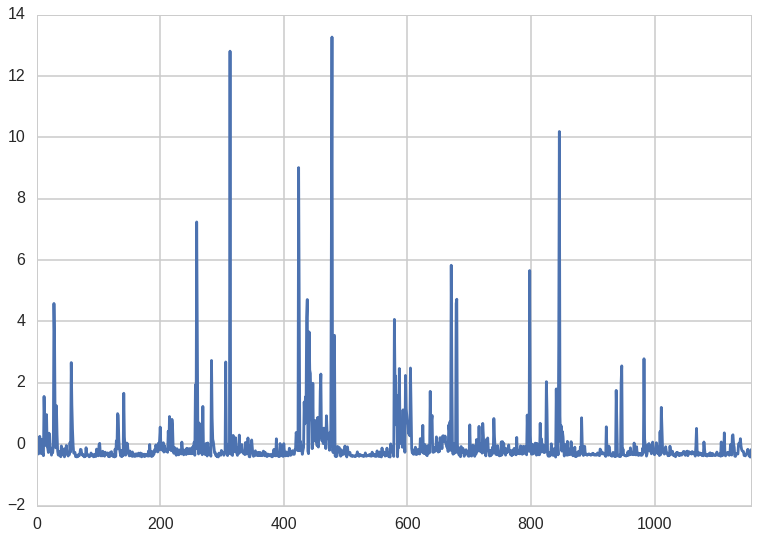

In [34]:
train[train.columns[-4]].plot();

** Plot pH **

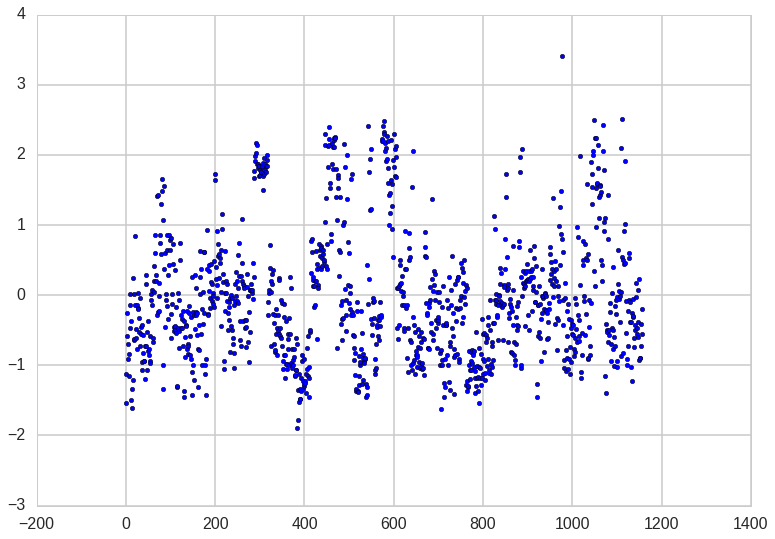

In [47]:
plt.scatter(np.arange(0, len(train)), train[train.columns[-3]]);

** Plot SOC.**

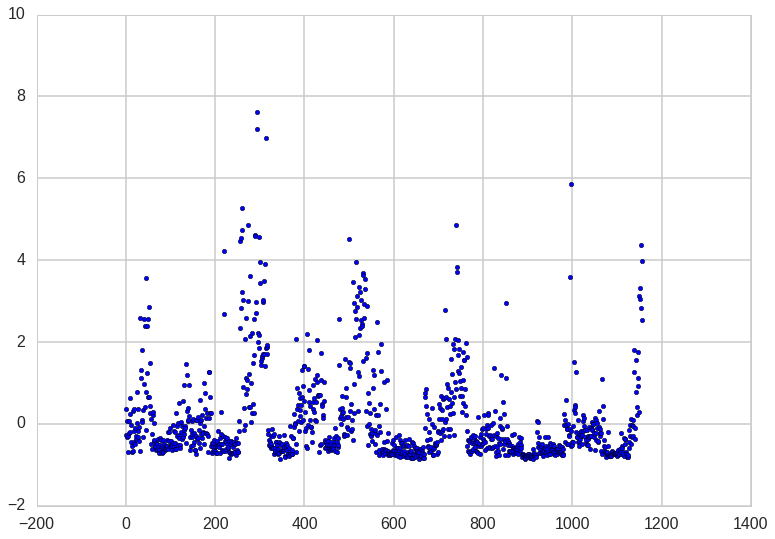

In [46]:
plt.scatter(np.arange(0, len(train)), train[train.columns[-2]]);

** Plot Sand. **

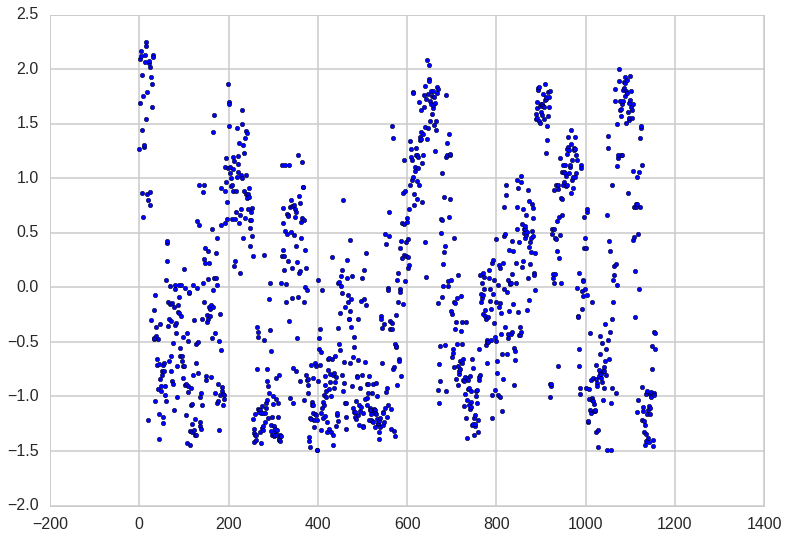

In [45]:
plt.scatter(np.arange(0, len(train)), train[train.columns[-1]]);

** Correlated Features **

In [43]:
data = pd.concat((train, test), axis=0)

In [48]:
data[train.columns[1:-6]].corr()

,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,m7480.61,...,EVI,LSTD,LSTN,REF1,REF2,REF3,REF7,RELI,TMAP,TMFI
m7497.96,1.000000,0.999873,0.999469,0.999421,0.999580,0.999697,0.999880,0.999444,0.999231,0.999217,...,0.120030,-0.132760,-0.022717,-0.155229,-0.048323,-0.083910,-0.211041,0.259250,0.138113,0.088082
m7496.04,0.999873,1.000000,0.999854,0.999737,0.999506,0.999380,0.999836,0.999816,0.999710,0.999697,...,0.123067,-0.133833,-0.018780,-0.155552,-0.044133,-0.083822,-0.211496,0.259741,0.140825,0.090094
m7494.11,0.999469,0.999854,1.000000,0.999870,0.999250,0.998804,0.999479,0.999894,0.999920,0.999906,...,0.125214,-0.133987,-0.014707,-0.155047,-0.040022,-0.083292,-0.211130,0.260430,0.143835,0.093013
m7492.18,0.999421,0.999737,0.999870,1.000000,0.999630,0.999074,0.999433,0.999699,0.999717,0.999690,...,0.121634,-0.130026,-0.014056,-0.151598,-0.040485,-0.080705,-0.207822,0.258865,0.141566,0.092523
m7490.25,0.999580,0.999506,0.999250,0.999630,1.000000,0.999780,0.999581,0.999150,0.998981,0.998942,...,0.116000,-0.126479,-0.018236,-0.149174,-0.045872,-0.078750,-0.205516,0.256242,0.135520,0.087838
m7488.32,0.999697,0.999380,0.998804,0.999074,0.999780,1.000000,0.999726,0.998880,0.998552,0.998521,...,0.115791,-0.128497,-0.022429,-0.151498,-0.049926,-0.080215,-0.207863,0.255647,0.133035,0.084059
m7486.39,0.999880,0.999836,0.999479,0.999433,0.999581,0.999726,1.000000,0.999639,0.999402,0.999389,...,0.121921,-0.133580,-0.020083,-0.155626,-0.046599,-0.083022,-0.212024,0.257619,0.137679,0.086152
m7484.46,0.999444,0.999816,0.999894,0.999699,0.999150,0.998880,0.999639,1.000000,0.999963,0.999956,...,0.126957,-0.135958,-0.014693,-0.156994,-0.040706,-0.083970,-0.213464,0.259454,0.143362,0.090751
m7482.54,0.999231,0.999710,0.999920,0.999717,0.998981,0.998552,0.999402,0.999963,1.000000,0.999997,...,0.127462,-0.135962,-0.013699,-0.156956,-0.039696,-0.084248,-0.213318,0.260162,0.145041,0.092625
m7480.61,0.999217,0.999697,0.999906,0.999690,0.998942,0.998521,0.999389,0.999956,0.999997,1.000000,...,0.127522,-0.136324,-0.014263,-0.157489,-0.040344,-0.084812,-0.213783,0.260239,0.145228,0.092634


** Many of the features seem correlated. **

** Since many of the feature values within a band are correlated lets group them by the band number and use the aggregated mean as the single feature which represents whole of the band. **

In [57]:
# group by wavelength
spectral_band = re.compile(r'([a-z]+)([0-9]+)')

def group_by_wavelength(column_name):
    match = spectral_band.match(column_name)
    
    if match:
        alpha, numeric = match.groups()
        n = len(numeric)
        numeric = int(numeric)
        return str(numeric // ( 10 ** (n - 1) ))
    else:
        return column_name

train_by_wavelength = train.groupby(group_by_wavelength, axis=1)

In [67]:
train_by_wavelength.size()

1        519
2        518
3        519
4        518
5        520
6        569
7        311
8         52
9         52
BSAN       1
BSAS       1
BSAV       1
CTI        1
Ca         1
Depth      1
ELEV       1
EVI        1
LSTD       1
LSTN       1
P          1
PIDN       1
REF1       1
REF2       1
REF3       1
REF7       1
RELI       1
SOC        1
Sand       1
TMAP       1
TMFI       1
pH         1
dtype: int64

** Observe the target variables. **

In [107]:
scaler = MinMaxScaler()
scaler.fit(train.Ca)
Ca = scaler.transform(train.Ca)

scaler = MinMaxScaler()
scaler.fit(train.P)
P = scaler.transform(train.P)

scaler = MinMaxScaler()
scaler.fit(train.Sand)
Sand = scaler.transform(train.Sand)

scaler = MinMaxScaler()
scaler.fit(train.SOC)
SOC = scaler.transform(train.SOC)

scaler = MinMaxScaler()
scaler.fit(train.pH)
pH = scaler.transform(train.pH)

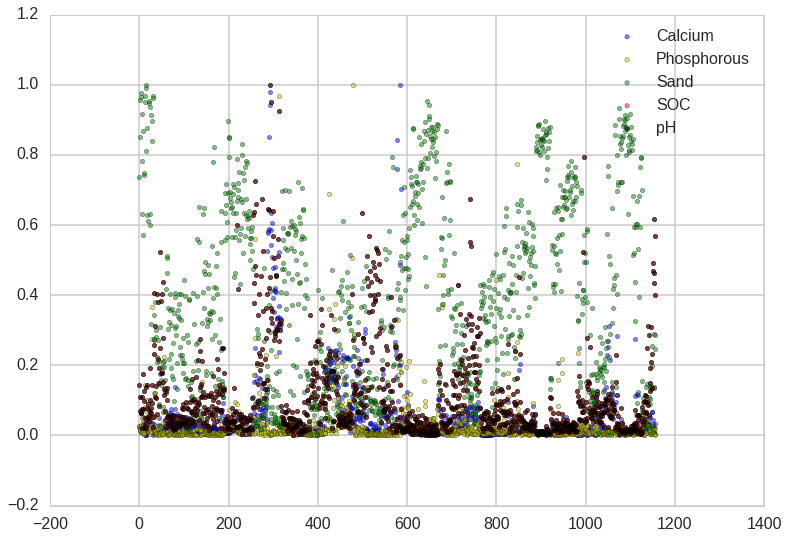

In [108]:
plt.scatter(np.arange(0, len(train)), Ca, c='b', alpha=.5, label='Calcium')
plt.scatter(np.arange(0, len(train)), P, c='y', alpha=.5, label='Phosphorous')
plt.scatter(np.arange(0, len(train)), Sand, c='g', alpha=.5, label='Sand')
plt.scatter(np.arange(0, len(train)), SOC, c='r', alpha=.5, label='SOC')
plt.scatter(np.arange(0, len(train)), SOC, c='k', alpha=.5, label='pH')
plt.legend(loc='best');

In [114]:
spectral_band = re.compile(r'([a-z]+)([0-9]+)')

def group_by_wavelength(column_names):
    band_dict = defaultdict(list)
    
    for col in column_names:
        match = spectral_band.match(col)

        alpha, numeric = match.groups()
        n = len(numeric)
        

        band_dict[int(numeric[0]) * (10 ** (n - 1))].append(col)
    
    return band_dict

band_dict = group_by_wavelength(train.columns[1:-21])

In [132]:
keys = list(band_dict.keys())

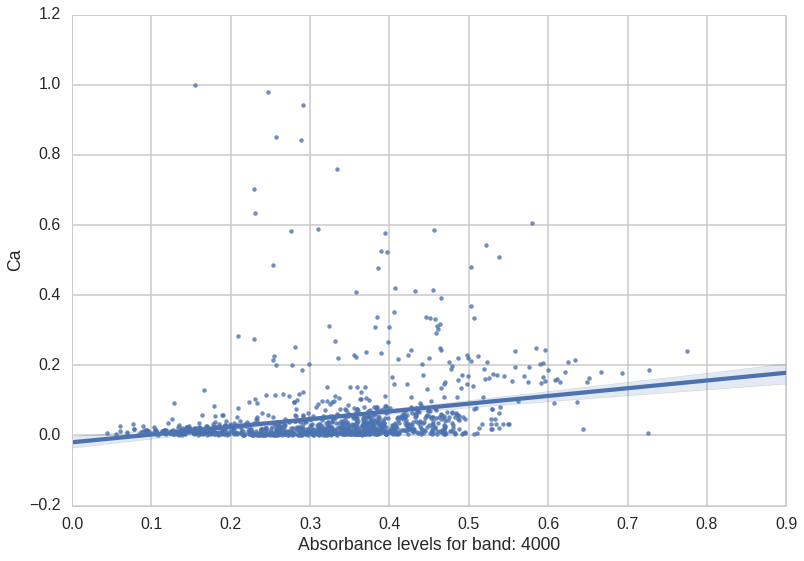

In [155]:
band_name = keys[0]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(mean_values, Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

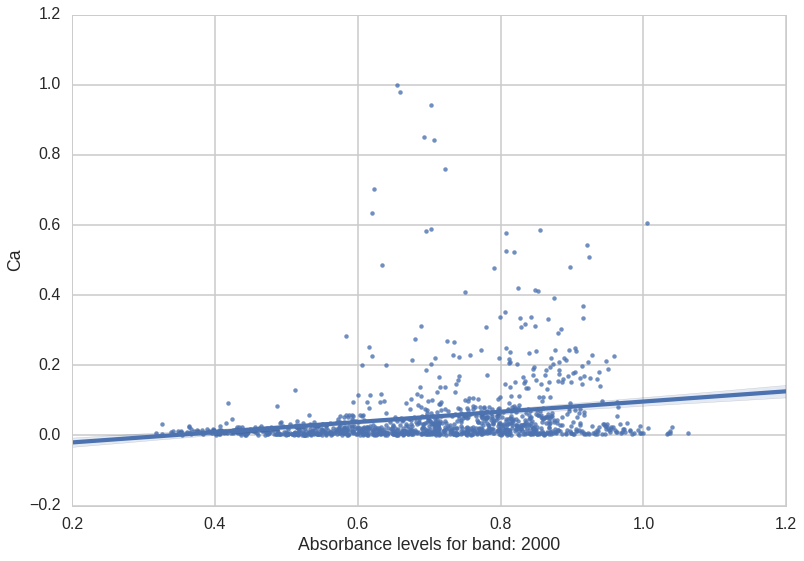

In [154]:
band_name = keys[1]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(mean_values, Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

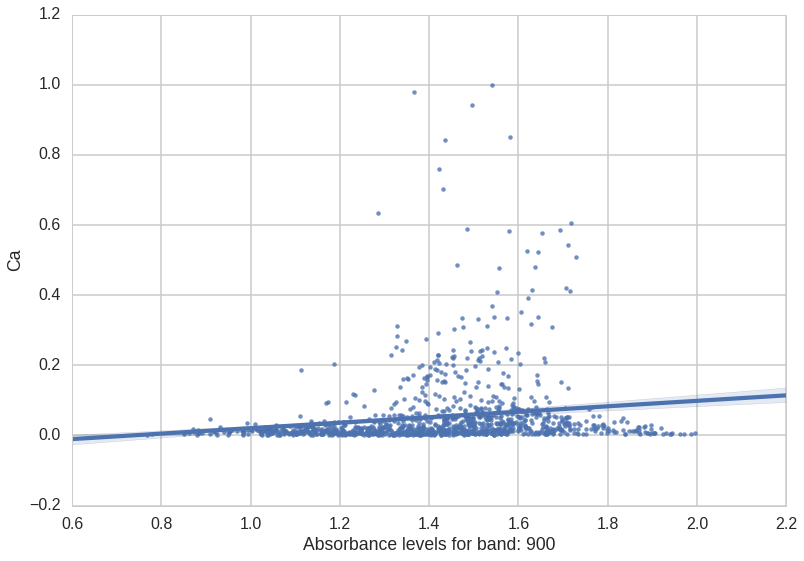

In [153]:
band_name = keys[2]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(mean_values, Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

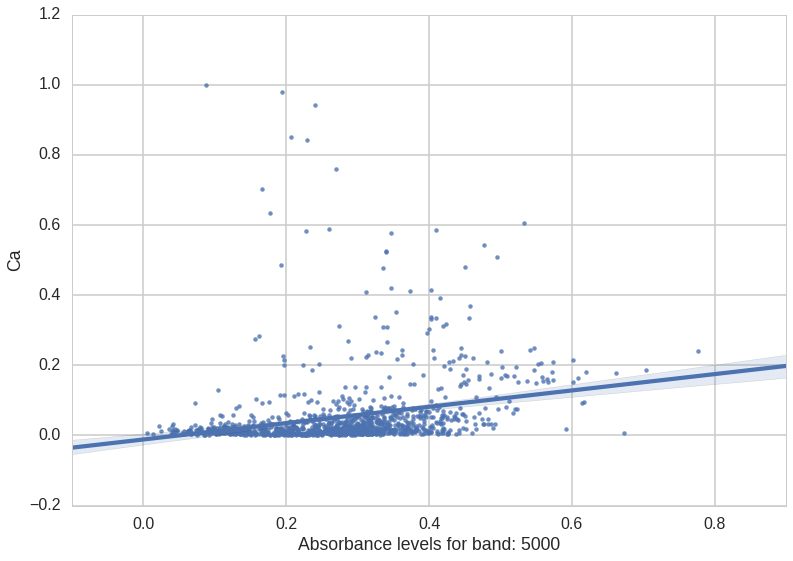

In [152]:
band_name = keys[3]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(mean_values, Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

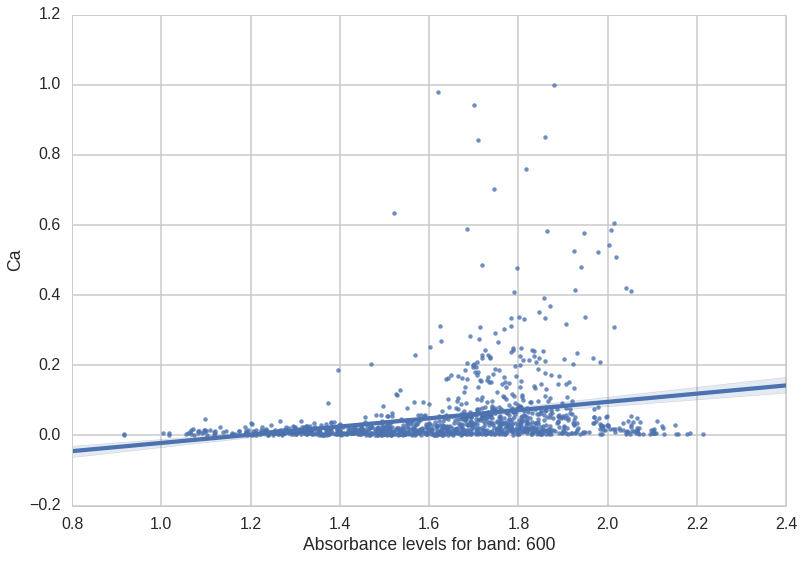

In [151]:
band_name = keys[4]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(mean_values, Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

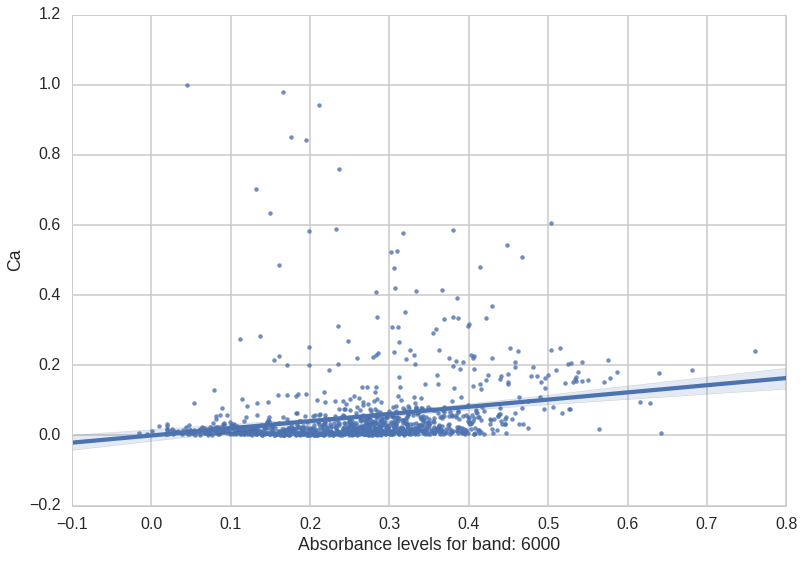

In [150]:
band_name = keys[5]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(mean_values, Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

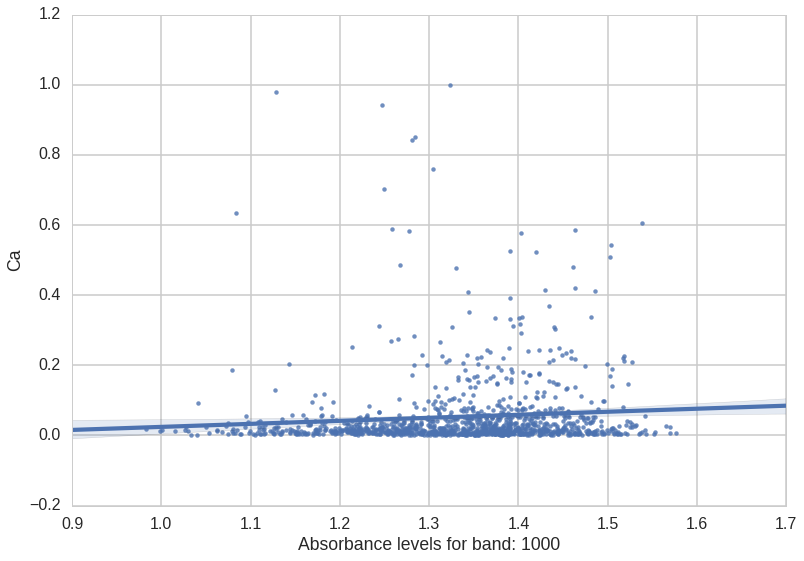

In [149]:
band_name = keys[6]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(mean_values, Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

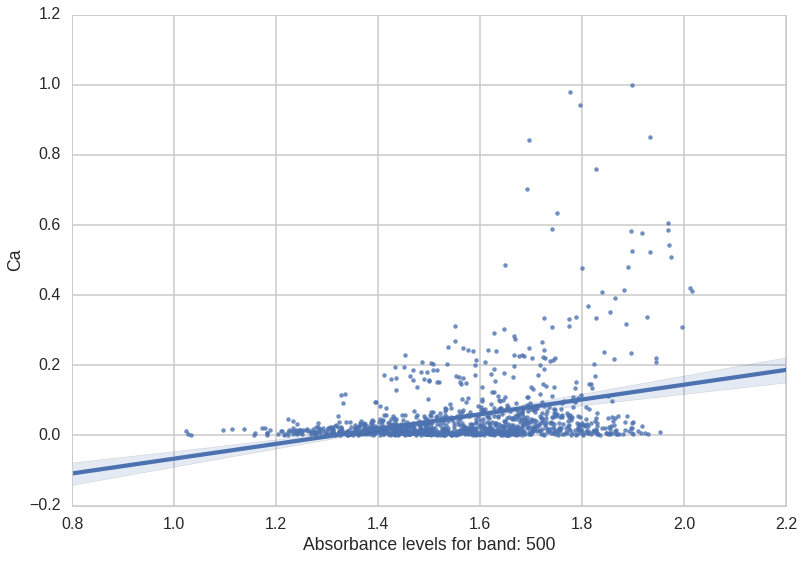

In [148]:
band_name = keys[7]

mean_values = train[band_dict[band_name]].mean(axis=1)
sns.regplot(x=mean_values, y=Ca)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

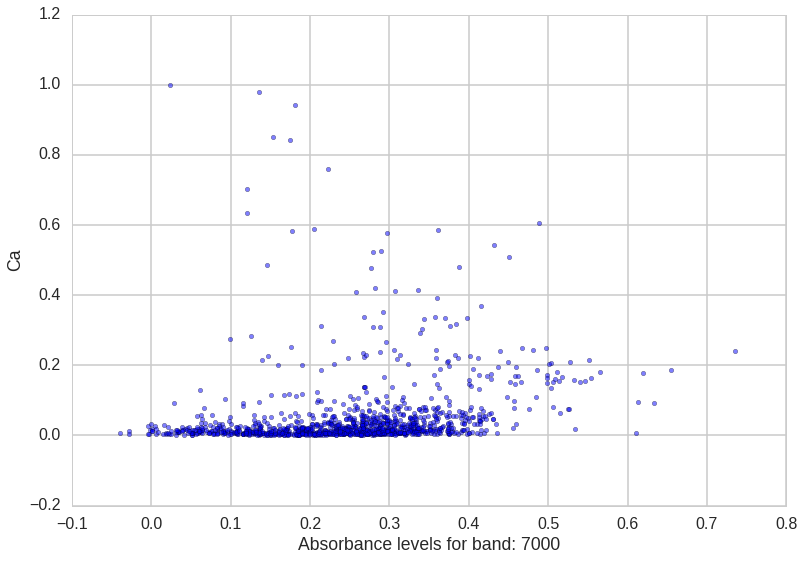

In [141]:
band_name = keys[8]

mean_values = train[band_dict[band_name]].mean(axis=1)
plt.scatter(mean_values, Ca, alpha=0.5)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

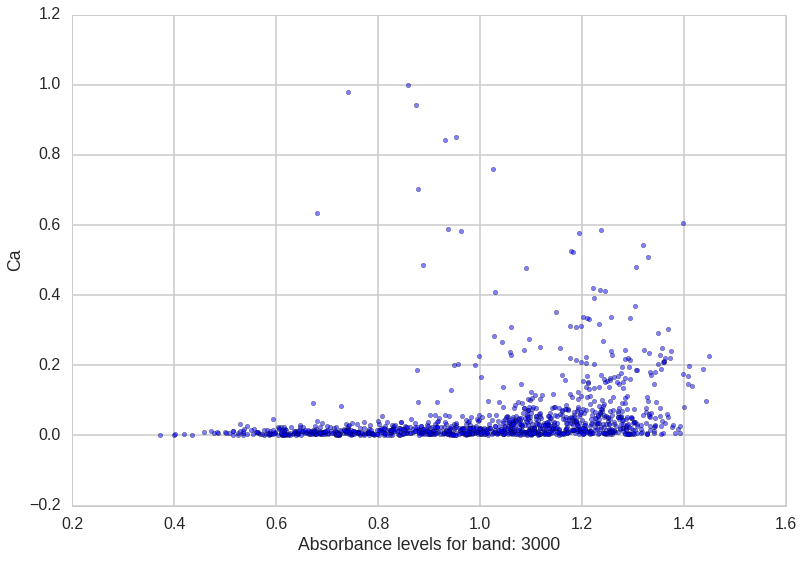

In [142]:
band_name = keys[9]

mean_values = train[band_dict[band_name]].mean(axis=1)
plt.scatter(mean_values, Ca, alpha=0.5)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

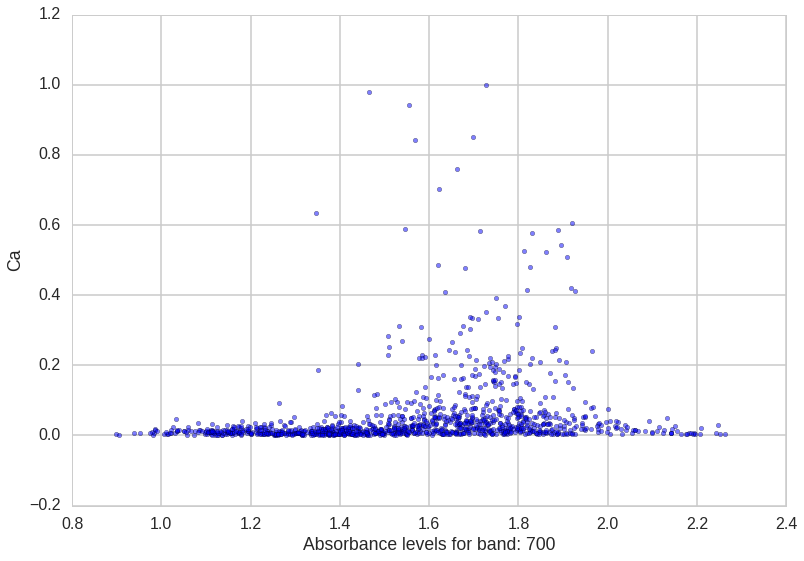

In [143]:
band_name = keys[10]

mean_values = train[band_dict[band_name]].mean(axis=1)
plt.scatter(mean_values, Ca, alpha=0.5)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

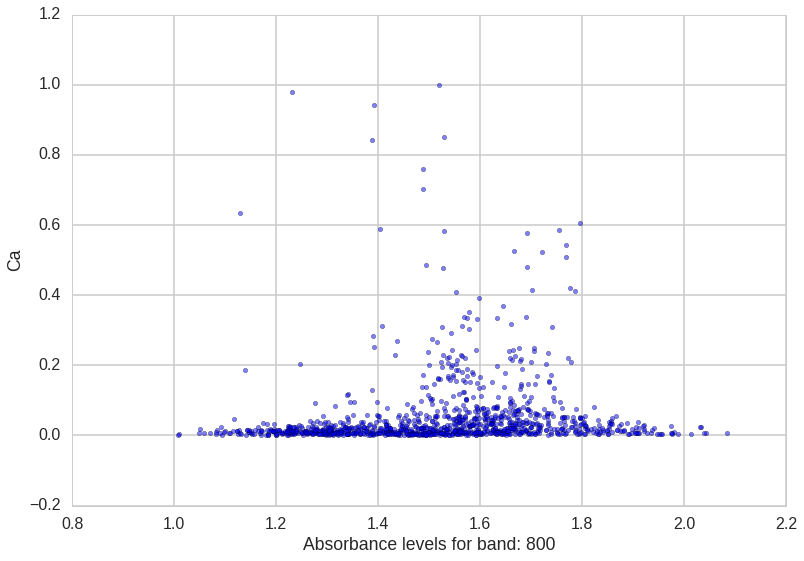

In [145]:
band_name = keys[11]

mean_values = train[band_dict[band_name]].mean(axis=1)
plt.scatter(mean_values, Ca, alpha=0.5)
plt.xlabel('Absorbance levels for band: %s'%band_name)
plt.ylabel('Ca');

** Feature Importance. **

** Data Preparation. **

In [30]:
train_ = train[train.columns[1:-5]]
train_['Depth'] = (train_.Depth == 'Topsoil').astype(np.int)

** Objective of this function. **

Way of calculating relative strength of each feature by first binning them in equal proportion and then calculating the $R^2$ with the target variable

* Function that would bin the variable.
* Function that would calculate the $R^2$ with a given target variable.

** This strategy was discussed in one of the winning solutions. **

In [62]:
def calculate_r_squared(X, y):
    slope, intercept, r_value, p_value, std_err = linregress(X, y)
    return r_value ** 2

def calculate_score(X, y, bins):
    X_agg = []
    y_agg = []
    
    for bin_ in range(bins.nunique()):
        mask = (bins == bin_)

        X_agg.append(X.loc[mask].mean())
        y_agg.append(y.loc[mask].mean())
    
    X_agg = np.array(X_agg)
    y_agg = np.array(y_agg)
    
    r_squared = calculate_r_squared(X_agg, y_agg)
    
    return r_squared
    
    
def feature_r_squared(X, y, features, bins):
    return [calculate_score(X[feature], y, bins) for feature in features]
    
def feature_relevance(X, y, nbins=8):
    
    features = X.columns
    bins = pd.cut(X[features[0]], nbins, labels=False)
     
    return feature_r_squared(X, y, features, bins)

In [63]:
feature_relevance_Ca = feature_relevance(train_, train.Ca)
feature_relevance_P = feature_relevance(train_, train.P)
feature_relevance_Sand = feature_relevance(train_, train.Sand)
feature_relevance_SOC = feature_relevance(train_, train.SOC)
feature_relevance_pH = feature_relevance(train_, train.pH)

In [64]:
feature_rel_df = pd.DataFrame({'variables': train_.columns, 
                               'Ca_r_squared': feature_relevance_Ca,
                               'P_r_squared': feature_relevance_P,
                               'Sand_r_squared': feature_relevance_Sand,
                               'SOC_r_squared': feature_relevance_SOC,
                               'pH_r_squared': feature_relevance_pH
                              })

In [76]:
feature_rel_df.sort_values(by='Ca_r_squared', ascending=False)[:2000]

,Ca_r_squared,P_r_squared,SOC_r_squared,Sand_r_squared,pH_r_squared,variables
3590,0.937086,0.971326,0.477539,0.567637,0.350653,RELI
3265,0.920196,0.790349,0.759582,0.849683,0.319505,m1201.45
3266,0.920118,0.789309,0.760665,0.850785,0.319807,m1199.52
3264,0.920041,0.791040,0.758788,0.848831,0.319032,m1203.38
3267,0.919812,0.787895,0.762065,0.852144,0.319958,m1197.59
3263,0.919684,0.791435,0.758208,0.848164,0.318438,m1205.31
3268,0.919341,0.786224,0.763650,0.853627,0.320027,m1195.66
3262,0.919130,0.791493,0.757838,0.847669,0.317791,m1207.23
3269,0.918772,0.784491,0.765222,0.855061,0.320054,m1193.73
3261,0.918354,0.791169,0.757708,0.847379,0.317089,m1209.16


In [ ]:
# dump this dataframe onto dis
joblib.dump(feature_rel_df, os.path.join(basepath, 'data/interim/feature_relevance'))